In [1]:
%matplotlib inline
THEANO_FLAGS='cuda.root=/usr/local/cuda-8.0/, device=cuda, floatX=float32'

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Input, BatchNormalization
from keras import backend as K
from keras.datasets import mnist
from keras.layers import add

from keras.models import Model
from keras.utils import plot_model
#from keras.utils.visualize_util import plot

from matplotlib import pyplot as plt

import itertools

from sklearn import svm, metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import numpy as np
# fix random seed for reproducibility
np.random.seed(7)

Using Theano backend.
1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33

418     }
419     if (self->dev_structure)
420     {
421         if (device_free(self->dev_structure))
422         {
423             fprintf(stderr,
424                     "CudaNdarray_uninit: error freeing dev_structure memory %p (self=%p)\n",
425                     self->dev_structure, self);
426             rval = -1;
427         }
428         self->dev_structure = NULL;
429     }
430     if (self->host_structure)
431     {
432         free(self->host_structure);
433         self->host_structure = NULL;
434     }
435     self->nd = -1;
436     Py_XDECREF(self->base);
437     self->base = NULL;
438     return rval;
439 }
440 
441 
442 //make the rightmost coords change fastest
443 //TODO: why does a downward for-loop not work????
444 //TODO: use the log2_dims and driver code to remove / and %
445 //TODO: skip the last division (when d == 0)
446 #define decl_k_elemwise_unary_rowmajor(name, F) \
447 __global__ void name (unsigned int numEls,  \
448         unsigned int nd, \
449     

1491     CudaNdarray * self = (CudaNdarray *)py_self;
1492     CudaNdarray * other = (CudaNdarray *)py_other;
1493     if(!CudaNdarray_is_c_contiguous(self) || !CudaNdarray_is_c_contiguous(other)){
1494         PyErr_SetString(PyExc_TypeError, "We have implementet only the c_contiguous version for now.");
1495         return NULL;
1496     }
1497 
1498     //standard elemwise size checks
1499     if (self->nd != other->nd)
1500     {
1501         PyErr_SetString(PyExc_TypeError, "CudaNdarray_add: need same number of dims");
1502         return NULL;
1503     }
1504     //standard elemwise dim checks
1505     unsigned int size = 1;
1506     for (int i = 0; i< self->nd; ++i)
1507     {
1508         if (CudaNdarray_HOST_DIMS(self)[i] != CudaNdarray_HOST_DIMS(other)[i])
1509         {
1510             PyErr_SetString(PyExc_TypeError, "need same dimensions");
1511             return NULL;
1512         }
1513         size *= (unsigned int) CudaNdarray_HOST_DIMS(self)[i];
1514     }
1515     

2702             Py_XDECREF(rval);
2703             return NULL;
2704         }
2705 
2706     }
2707     return rval;
2708 }
2709 
2710 static int
2711 CudaNdarray_set_strides(CudaNdarray *self, PyObject *value, void *closure)
2712 {
2713     //npy_intp newstrides_bytes[PyTuple_Size(value)];
2714     if (PyTuple_Check(value)){
2715         if (PyTuple_Size(value) != CudaNdarray_NDIM(self)){
2716             PyErr_SetString(PyExc_ValueError,
2717                             "The new strides tuple must have the same length"
2718                             " as the number of dimensions");
2719             return -1;
2720         }
2721     }else if (PyList_Check(value)){
2722         if (PyList_Size(value) != CudaNdarray_NDIM(self)){
2723             PyErr_SetString(PyExc_ValueError,
2724                             "The new strides list must have the same length"
2725                             " as the number of dimensions");
2726             return -1;
2727         }
2728     }else{

3613 PyMODINIT_FUNC
3614 initcuda_ndarray(void)
3615 #endif
3616 {
3617     import_array();
3618 
3619     PyObject* m;
3620 
3621     if (PyType_Ready(&CudaNdarrayType) < 0) {
3622 #if PY_MAJOR_VERSION == 3
3623         return NULL;
3624 #else
3625         return;
3626 #endif
3627     }
3628 
3629 #if PY_MAJOR_VERSION == 3
3630     m = PyModule_Create(&cuda_ndarray_moduledef);
3631 #else
3632     m = Py_InitModule3(CNDA_MOD_NAME, module_methods, CNDA_DOCSTRING);
3633 #endif
3634 
3635     if (m == NULL) {
3636 #if PY_MAJOR_VERSION == 3
3637         return NULL;
3638 #else
3639         return;
3640 #endif
3641     }
3642 
3643     Py_INCREF(&CudaNdarrayType);
3644     PyModule_AddObject(m, "CudaNdarray", (PyObject *)&CudaNdarrayType);
3645 #if COMPUTE_GPU_MEM_USED
3646     for(int i=0;i<TABLE_SIZE;i++){
3647         _alloc_size_table[i].ptr=NULL;
3648         _alloc_size_table[i].size=0;
3649     }
3650 #endif
3651     //    cublasInit();
3652     //if (0&&CUBLAS_STATUS_SUCCESS != cubl

4691                 }
4692                 break;
4693             case 2:
4694                 {
4695                     int rd = reduce_dim0+1;
4696                     for (; rd < nd; ++rd)
4697                     {
4698                         if (a_str[rd] && (!z_str[rd])) // this means 'rd' is a dimension we are reducing over
4699                             break;
4700                     }
4701                     const int stride0 = a_str[reduce_dim0];
4702                     const int stride1 = a_str[rd];
4703                     for (int ii = 0; ii < dims_a[rd]; ++ii)
4704                     {
4705                         const float * a_data_ri = a_data_i + ii * stride1;
4706                         const float * a_data_ri_max = a_data_ri + dims_a[reduce_dim0] * stride0;
4707                         while (a_data_ri != a_data_ri_max)
4708                         {
4709                             sum += a_data_ri[0];
4710                             a_data_ri += stride


['nvcc', '-shared', '-O3', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/home/nani/.theano/compiledir_Linux-4.10--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.3-64/cuda_ndarray', '-I/home/nani/anaconda3/envs/jupyter-env/lib/python3.5/site-packages/theano/sandbox/cuda', '-I/home/nani/anaconda3/envs/jupyter-env/lib/python3.5/site-packages/numpy/core/include', '-I/home/nani/anaconda3/envs/jupyter-env/include/python3.5m', '-I/home/nani/anaconda3/envs/jupyter-env/lib/python3.5/site-packages/theano/gof', '-L/home/nani/anaconda3/envs/jupyter-env/lib', '-o', '/home/nani/.theano/compiledir_Linux-4.10--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.3-64/cuda_ndarray/cuda_ndarray.so', 'mod.cu', '-lcublas', '-lpython3.5m', '-lcudart']


/home/nani/anaconda3/envs/jupyter-env/lib/python3.5/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Can not use cuDNN on context None: Device not supported
Mapped name None to device cuda0: GeForce GT 630M (0000:01:00.0)


In [2]:
from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[GpuElemwise{exp,no_inplace}(<GpuArrayType<None>(float32, (False,))>), HostFromGpu(gpuarray)(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.515627 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


## 1. Preprocess input data for Keras

In [3]:
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


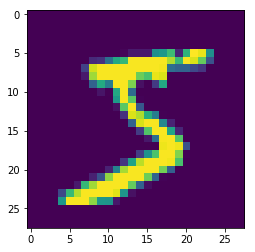

In [5]:
plt.imshow(X_train[0])

In [6]:
K.image_data_format()

'channels_last'

In [7]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

## 2. Preprocess class labels for Keras

In [9]:
print(y_train.shape)

(60000,)


In [10]:
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]


In [11]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = keras.utils.to_categorical(y_train, num_classes=10)
Y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [12]:
print(Y_train.shape)

(60000, 10)


## 3. Define model architecture: Conv2D and Dense layers

In [38]:
model = Sequential()
 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

## 4. Compile model

In [39]:
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 5. Fit model

In [17]:
model.fit(
    # Feature matrix
    X_train, 
    # Target class one-hot-encoded
    Y_train,
    # Iterations to be run if not stopped by EarlyStopping
    epochs=100,
    callbacks=[
        EarlyStopping(monitor='val_loss',patience=5),
        ModelCheckpoint(
            'mnist_model.hdf5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ],
    verbose=1,
    validation_split=0.1,
    batch_size=32, 
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 232s - loss: 0.0297 - acc: 0.9905 - val_loss: 0.0325 - val_acc: 0.9923
Epoch 2/100
54000/54000 [==============================] - 230s - loss: 0.0272 - acc: 0.9913 - val_loss: 0.0291 - val_acc: 0.9923
Epoch 3/100
54000/54000 [==============================] - 228s - loss: 0.0258 - acc: 0.9917 - val_loss: 0.0333 - val_acc: 0.9922
Epoch 4/100
54000/54000 [==============================] - 223s - loss: 0.0238 - acc: 0.9919 - val_loss: 0.0345 - val_acc: 0.9927
Epoch 5/100
54000/54000 [==============================] - 223s - loss: 0.0212 - acc: 0.9928 - val_loss: 0.0355 - val_acc: 0.9923
Epoch 6/100
54000/54000 [==============================] - 223s - loss: 0.0236 - acc: 0.9923 - val_loss: 0.0303 - val_acc: 0.9937
Epoch 7/100
54000/54000 [==============================] - 223s - loss: 0.0211 - acc: 0.9929 - val_loss: 0.0313 - val_acc: 0.9928
Epoch 8/100
54000/54000 [================

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## 6. Train evaluation

In [40]:
#Evaluate
model.load_weights("mnist_model.hdf5")
score_train = model.evaluate(X_train, Y_train, verbose=0)
print("loss:%0.4f"%score_train[0])
print("accuracy:%0.4f"%score_train[1])

loss:0.0070
accuracy:0.9981


In [41]:
# Predict classes
model.load_weights("mnist_model.hdf5")
y_train_preds = model.predict_classes(X_train)

60000/60000 [==============================] - 115s   


In [42]:
#sklearn accuracy score
accuracy_score(y_train, y_train_preds)

0.99814999999999998

In [43]:
#sklearn precision score
precision_score(y_train, y_train_preds,average=None)

array([ 0.9994935 ,  0.99748372,  0.99949571,  0.99788239,  0.99522021,
        0.99796936,  0.99898614,  0.99808582,  0.99948604,  0.99747219])

In [44]:
#sklearn recall
recall_score(y_train, y_train_preds,average=None)

array([ 0.9994935 ,  0.99955503,  0.9979859 ,  0.99918447,  0.99794591,
        0.99723298,  0.99898614,  0.99872306,  0.99709451,  0.99495714])

### Confusion matrix

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5920    0    0    0    0    0    0    1    1    1]
 [   0 6739    1    0    0    0    0    2    0    0]
 [   1    5 5946    1    0    0    0    4    0    1]
 [   0    0    1 6126    0    1    0    1    1    1]
 [   0    4    0    0 5830    0    1    1    0    6]
 [   1    1    1    7    0 5406    4    0    0    1]
 [   0    0    0    0    1    4 5912    0    1    0]
 [   0    5    0    0    2    0    0 6257    0    1]
 [   1    1    0    1    4    5    1    0 5834    4]
 [   0    1    0    4   21    1    0    3    0 5919]]


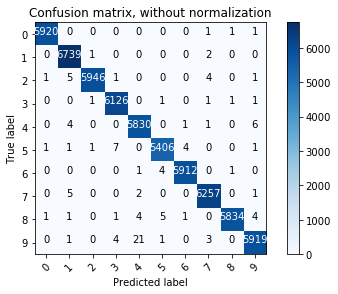

In [24]:
confMatrix = confusion_matrix(y_train, y_train_preds)
plot_confusion_matrix(confMatrix, classes=[0,1,2,3,4,5,6,7,8,9],
                        title='Confusion matrix, without normalization')

## 7. Test evaluation

In [26]:
#Evaluate
model.load_weights("mnist_model.hdf5")
score_test = model.evaluate(X_test, Y_test, verbose=0)
print("loss:%0.4f"%score_test[0])
print("accuracy:%0.4f"%score_test[1])

loss:0.0311
accuracy:0.9911


In [19]:
#Predict classes
model.load_weights("mnist_model.hdf5")
y_test_preds = model.predict_classes(X_test)

 9984/10000 [============================>.] - ETA: 0s

In [20]:
#sklearn accuracy score
accuracy_score(y_test, y_test_preds)

0.99109999999999998

In [21]:
#sklearn precision score
precision_score(y_test, y_test_preds,average=None)

array([ 0.99186992,  0.9877836 ,  0.99512195,  0.99017682,  0.99084435,
        0.98989899,  0.99160546,  0.98550725,  0.99380805,  0.99497992])

In [22]:
#sklearn recall
recall_score(y_test, y_test_preds,average=None)

array([ 0.99591837,  0.99735683,  0.98837209,  0.9980198 ,  0.99185336,
        0.98878924,  0.98643006,  0.9922179 ,  0.98870637,  0.98216056])

Confusion matrix, without normalization
[[ 976    1    0    1    0    0    2    0    0    0]
 [   0 1132    0    0    0    1    0    1    1    0]
 [   1    4 1020    0    0    0    0    7    0    0]
 [   0    0    0 1008    0    2    0    0    0    0]
 [   0    0    0    0  974    0    4    1    1    2]
 [   1    0    0    7    0  882    2    0    0    0]
 [   2    3    0    2    1    4  945    0    1    0]
 [   0    4    3    0    0    0    0 1020    1    0]
 [   3    0    2    0    2    0    0    1  963    3]
 [   1    2    0    0    6    2    0    5    2  991]]


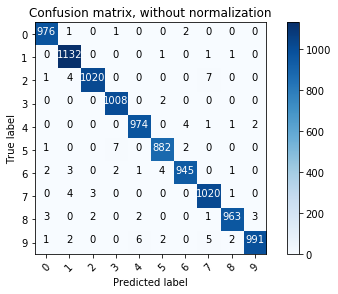

In [23]:
#Confusion matrix
confMatrix = confusion_matrix(y_test, y_test_preds)
plot_confusion_matrix(confMatrix, classes=[0,1,2,3,4,5,6,7,8,9],
                        title='Confusion matrix, without normalization')

## 3.2 Define an other model architecture: Dense layers

In [117]:
input_shape = (28, 28,1)
modeld = Sequential()
modeld.add(Flatten(input_shape=input_shape))
modeld.add(Dense(128, activation='relu'))
modeld.add(Dropout(0.5))
modeld.add(Dense(Y_train.shape[1], activation='softmax'))

In [118]:
modeld.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [121]:
modeld.fit(
    # Feature matrix
    X_train, 
    # Target class one-hot-encoded
    Y_train,
    # Iterations to be run if not stopped by EarlyStopping
    epochs=100,
    callbacks=[
        EarlyStopping(monitor='val_loss',patience=5),
        ModelCheckpoint(
            'mnist_model2.hdf5', 
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ],
    verbose=1,
    validation_split=0.1,
    batch_size=32, 
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 11s - loss: 0.4145 - acc: 0.8767 - val_loss: 0.1422 - val_acc: 0.9615
Epoch 2/100
54000/54000 [==============================] - 9s - loss: 0.2302 - acc: 0.9328 - val_loss: 0.1102 - val_acc: 0.9692
Epoch 3/100
54000/54000 [==============================] - 9s - loss: 0.1920 - acc: 0.9419 - val_loss: 0.0933 - val_acc: 0.9733
Epoch 4/100
54000/54000 [==============================] - 10s - loss: 0.1692 - acc: 0.9493 - val_loss: 0.0859 - val_acc: 0.9747
Epoch 5/100
54000/54000 [==============================] - 10s - loss: 0.1522 - acc: 0.9542 - val_loss: 0.0807 - val_acc: 0.9768
Epoch 6/100
54000/54000 [==============================] - 10s - loss: 0.1417 - acc: 0.9567 - val_loss: 0.0773 - val_acc: 0.9805
Epoch 7/100
54000/54000 [==============================] - 9s - loss: 0.1347 - acc: 0.9582 - val_loss: 0.0751 - val_acc: 0.9778
Epoch 8/100
54000/54000 [==========================

In [123]:
modeld.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 101,770.0
Trainable params: 101,770.0
Non-trainable params: 0.0
_________________________________________________________________


## Evaluation function

In [21]:
def sklearn_evaluations(X,y,model,model_name):
    # Predict classes
    model.load_weights(model_name)
    y_preds = model.predict_classes(X)
    #sklearn accuracy score
    print("\nAccuracy:%0.4f"%accuracy_score(y, y_preds))
    #sklearn precision score
    print("Precision:")
    print(precision_score(y, y_preds,average=None))
    #sklearn recall
    print("Recall:")
    print(recall_score(y, y_preds,average=None))
    #Confusion matrix
    confMatrix = confusion_matrix(y, y_preds)
    plot_confusion_matrix(confMatrix, classes=[0,1,2,3,4,5,6,7,8,9],
                        title='Confusion matrix, without normalization')

## 6. Train evaluation

59776/60000 [============================>.] - ETA: 0s
Accuracy:0.9883
Precision:
[ 0.9947582   0.99317406  0.99221395  0.98719632  0.9922534   0.98293891
  0.99508475  0.98213156  0.98229184  0.98046745]
Recall:
[ 0.99324667  0.99273213  0.98388721  0.98091665  0.98664841  0.98837853
  0.99205813  0.99138069  0.9859853   0.98722474]
Confusion matrix, without normalization
[[5883    0    2    1    2    3    8    2   18    4]
 [   1 6693    8    7    2    1    0   11   16    3]
 [   7    5 5862   15    9    1    1   37   19    2]
 [   1    0   12 6014    0   44    1   24   22   13]
 [   2   12    5    0 5764    0    3    4    3   49]
 [   4    0    2   20    3 5358   13    4    9    8]
 [   7    4    0    0    8   19 5871    0    9    0]
 [   1    8   11    3    5    2    0 6211    1   23]
 [   4   15    6   16    2   15    2    7 5769   15]
 [   4    2    0   16   14    8    1   24    7 5873]]


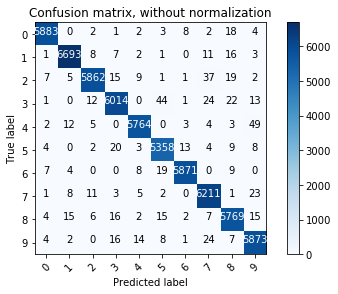

In [137]:
sklearn_evaluations(X_train,y_train,modeld,"mnist_model.hdf5")

## 7. Test evaluation

 9216/10000 [==========================>...] - ETA: 0s
Accuracy:0.9774
Precision:
[ 0.9837233   0.98683055  0.9813176   0.97435897  0.97948718  0.96909492
  0.98417722  0.96721311  0.97722567  0.96945813]
Recall:
[ 0.98673469  0.99030837  0.96705426  0.97821782  0.97250509  0.98430493
  0.97390397  0.97568093  0.96919918  0.97522299]
Confusion matrix, without normalization
[[ 967    0    2    2    1    2    3    1    2    0]
 [   0 1124    3    3    0    1    1    0    3    0]
 [   4    0  998    5    5    0    2   12    6    0]
 [   0    0    2  988    0   10    0    6    2    2]
 [   0    1    3    0  955    0    4    2    2   15]
 [   2    0    0    3    0  878    3    0    3    3]
 [   3    3    0    1    6    7  933    1    4    0]
 [   1    5    8    3    0    0    0 1003    0    8]
 [   5    1    1    5    3    5    1    6  944    3]
 [   1    5    0    4    5    3    1    6    0  984]]


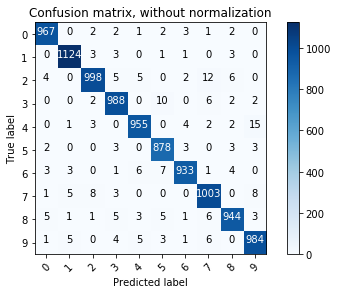

In [138]:
sklearn_evaluations(X_test,y_test,modeld,"mnist_model.hdf5")

## 3.3 Define model architecture: ResNet/HighwayNet

In [41]:
def conv_block(feat_maps_out, prev):
    prev = BatchNormalization(axis=1)(prev) # Specifying the axis and mode allows for later merging
    prev = Activation('relu')(prev)
    prev = Conv2D(feat_maps_out, (3, 3), padding='same')(prev) 
    #prev = BatchNormalization(axis=1)(prev) # Specifying the axis and mode allows for later merging
    #prev = Activation('relu')(prev)
    #prev = Conv2D(feat_maps_out, (3, 3), padding='same')(prev) 
    return prev

def skip_block(feat_maps_in, feat_maps_out, prev):
    if feat_maps_in != feat_maps_out:
        # This adds in a 1x1 convolution on shortcuts that map between an uneven amount of channels
        prev = Conv2D(feat_maps_out, (1, 1), padding='same')(prev)
    return prev 

def Residual(feat_maps_in, feat_maps_out, prev_layer):
    '''
    A customizable residual unit with convolutional and shortcut blocks
    Args:
      feat_maps_in: number of channels/filters coming in, from input or previous layer
      feat_maps_out: how many output channels/filters this block will produce
      prev_layer: the previous layer
    '''

    skip = skip_block(feat_maps_in, feat_maps_out, prev_layer)
    conv = conv_block(feat_maps_out, prev_layer)
    
    merged = add([skip,conv])

    print('Residual block mapping '+str(feat_maps_in)+' channels to '+str(feat_maps_out)+' channels built')
    return merged # the residual connection

In [42]:
#Egyszerubb halozat
img_rows = X_train.shape[1]  
img_cols = X_train.shape[2] 

inp = Input((img_rows, img_cols,1))
cnv = Conv2D(12, (3, 3), strides=[1,1], activation='relu', padding='same')(inp)#28*28/4=196 ami = 14*14
r = Residual(12, 32, cnv)
cnv2 = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(r)
fl = Flatten()(cnv2)
out = Dense(10)(fl)

modelr = Model(inputs=inp, outputs=out)

modelr.compile(optimizer=optimizers.Adam(), loss='mean_squared_error')

Residual block mapping 12 channels to 32 channels built


In [44]:
plot_model(modelr, to_file='model_simple2.png',show_shapes=True)

In [13]:
img_rows = X_train.shape[1]  
img_cols = X_train.shape[2] 

inp = Input((img_rows, img_cols,1))
cnv1 = Conv2D(32, (3, 3), strides=[2,2], activation='relu', padding='same')(inp)#28*28/4=196 ami = 14*14
r1 = Residual(32, 64, cnv1)
# An example residual unit coming after a convolutional layer. NOTE: the above residual takes the 64 output
# channels from the Convolutional2D layer as the first argument to the Residual function
r2 = Residual(64, 128, r1)
r3 = Residual(128, 256, r2)
cnv2 = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(r3)
# mintában a fenti conv2 volt az output, de shape probléma volt, így a következő 2 sort tettem bele, így a fit elkezdett futni
fl = Flatten()(cnv2)
out = Dense(10)(fl)
#out = Convolution2D(10,1, activation='sigmoid')(r3)

modelr = Model(inputs=inp, outputs=out)

modelr.compile(optimizer=optimizers.Adam(), loss='mean_squared_error')

Residual block mapping 32 channels to 64 channels built
Residual block mapping 64 channels to 128 channels built
Residual block mapping 128 channels to 256 channels built


In [14]:
plot_model(modelr, to_file='model.png',show_shapes=True)

In [43]:
modelr.fit(
    # Feature matrix
    X_train[:10000], 
    # Target class one-hot-encoded
    Y_train[:10000],
    # Iterations to be run if not stopped by EarlyStopping
    epochs=100,
    callbacks=[
        EarlyStopping(monitor='val_loss',patience=5),
        ModelCheckpoint(
            'mnist_residualmodel2.hdf5', 
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ],
    verbose=1,
    validation_split=0.1,
    batch_size=32, 
)

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 26s - loss: 0.0727 - val_loss: 0.0844
Epoch 2/100
9000/9000 [==============================] - 30s - loss: 0.0461 - val_loss: 0.0426
Epoch 3/100
9000/9000 [==============================] - 29s - loss: 0.0425 - val_loss: 0.0388
Epoch 4/100
9000/9000 [==============================] - 29s - loss: 0.0407 - val_loss: 0.0384
Epoch 5/100
9000/9000 [==============================] - 30s - loss: 0.0391 - val_loss: 0.0378
Epoch 6/100
9000/9000 [==============================] - 29s - loss: 0.0378 - val_loss: 0.0352
Epoch 7/100
9000/9000 [==============================] - 29s - loss: 0.0364 - val_loss: 0.0344
Epoch 8/100
9000/9000 [==============================] - 29s - loss: 0.0344 - val_loss: 0.0326
Epoch 9/100
9000/9000 [==============================] - 29s - loss: 0.0322 - val_loss: 0.0296
Epoch 10/100
9000/9000 [==============================] - 29s - loss: 0.0301 - val_loss: 0.0305
E

9000/9000 [==============================] - 28s - loss: 0.0220 - val_loss: 0.0232
Epoch 36/100
9000/9000 [==============================] - 27s - loss: 0.0220 - val_loss: 0.0228
Epoch 37/100
9000/9000 [==============================] - 27s - loss: 0.0219 - val_loss: 0.0222
Epoch 38/100
9000/9000 [==============================] - 29s - loss: 0.0217 - val_loss: 0.0230
Epoch 39/100
9000/9000 [==============================] - 27s - loss: 0.0218 - val_loss: 0.0248
Epoch 40/100
9000/9000 [==============================] - 25s - loss: 0.0217 - val_loss: 0.0225
Epoch 41/100
9000/9000 [==============================] - 23s - loss: 0.0216 - val_loss: 0.0223
Epoch 42/100
9000/9000 [==============================] - 23s - loss: 0.0215 - val_loss: 0.0226
Epoch 43/100
9000/9000 [==============================] - 23s - loss: 0.0214 - val_loss: 0.0248


In [25]:
model_name =  "mnist_residualmodel2.hdf5"
X = X_test
y = y_test
#Evaluate
modelr.load_weights(model_name)
score_test = modelr.evaluate(X, Y_test, verbose=0)
#print("loss:%0.4f"%score_test[0])
#print("accuracy:%0.4f"%score_test[1])

In [26]:
score_test

0.021452685222029685

In [27]:
# Predict classes
modelr.load_weights(model_name)
y_preds = modelr.predict(X) #a sima sklearn_learn nem jo mert mashogy kell predikalni ennel a haloosszeallitasnal

In [31]:
y_preds_max = np.argmax(y_preds,axis=1)


Accuracy:0.9500
Precision:
[ 0.94341463  0.95234043  0.94886922  0.9556213   0.96062176  0.96131301
  0.95753715  0.96258847  0.92139303  0.93891626]
Recall:
[ 0.98673469  0.98590308  0.93507752  0.95940594  0.94399185  0.91928251
  0.94154489  0.92607004  0.95071869  0.9444995 ]
Confusion matrix, without normalization
[[ 967    1    0    0    2    1    4    1    4    0]
 [   0 1119    2    1    1    0    4    1    7    0]
 [  12   12  965    0    4    0    4   12   23    0]
 [   2    0   12  969    0    3    3   11    8    2]
 [   0    9    5    0  927    0    6    0    4   31]
 [   8    3    0   26    1  820   15    2   15    2]
 [  17    6    0    0   10   19  902    0    4    0]
 [   2   15   27    3    6    1    1  952    7   14]
 [   9    3    5    3    5    5    3    2  926   13]
 [   8    7    1   12    9    4    0    8    7  953]]


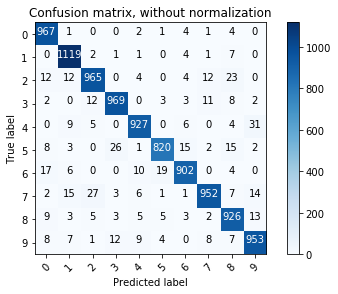

In [40]:
#sklearn accuracy score
print("\nAccuracy:%0.4f"%accuracy_score(y, y_preds_max))
#sklearn precision score
print("Precision:")
print(precision_score(y, y_preds_max,average=None))
#sklearn recall
print("Recall:")
print(recall_score(y, y_preds_max,average=None))
#Confusion matrix
confMatrix = confusion_matrix(y, y_preds_max)
plot_confusion_matrix(confMatrix, classes=[0,1,2,3,4,5,6,7,8,9],
                        title='Confusion matrix, without normalization')

# Trash

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow.contrib.slim as slim

In [ ]:
total_layers = 25 #Specify how deep we want our network
units_between_stride = int(total_layers / 5) ####must be integer

In [ ]:
def resUnit(input_layer,i):
    with tf.variable_scope("res_unit"+str(i),reuse=None):
        part1 = slim.batch_norm(input_layer,activation_fn=None)
        part2 = tf.nn.relu(part1)
        part3 = slim.conv2d(part2,64,[3,3],activation_fn=None)
        part4 = slim.batch_norm(part3,activation_fn=None)
        part5 = tf.nn.relu(part4)
        part6 = slim.conv2d(part5,64,[3,3],activation_fn=None)
        output = input_layer + part6
        return output

In [ ]:
tf.reset_default_graph()

In [ ]:
input_layer = tf.placeholder(shape=[None,28,28,1],dtype=tf.float32,name='input') #X_test hova?
label_layer = tf.placeholder(shape=[None],dtype=tf.int32) #y_test hova?
label_oh = slim.layers.one_hot_encoding(label_layer,10)

In [ ]:
layer1 = slim.conv2d(input_layer,64,[3,3],normalizer_fn=slim.batch_norm,scope='conv_'+str(0),reuse=None)
for i in range(5):
    for j in range(units_between_stride):
        layer1 = resUnit(layer1,j + (i*units_between_stride))
    layer1 = slim.conv2d(layer1,64,[3,3],stride=[2,2],normalizer_fn=slim.batch_norm,scope='conv_s_'+str(i))
    
top = slim.conv2d(layer1,10,[3,3],normalizer_fn=slim.batch_norm,activation_fn=None,scope='conv_top')

output = slim.layers.softmax(slim.layers.flatten(top))

loss = tf.reduce_mean(-tf.reduce_sum(label_oh * tf.log(output) + 1e-10, reduction_indices=[1]))
trainer = tf.train.AdamOptimizer(learning_rate=0.001)
update = trainer.minimize(loss)

### Valami más

In [ ]:
# Generate Predictions
predictions = {
  "classes": tf.argmax(
      input=logits, axis=1),
  "probabilities": tf.nn.softmax(
      logits, name="softmax_tensor")

In [240]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [241]:
accuracy_validation = slim.metrics.accuracy(tf.to_int32(tf.argmax(predictions_validation, 1)), tf.to_int32(tf.argmax(labels_validation, 1)))
  accuracy_test = slim.metrics.accuracy(tf.to_int32(tf.argmax(predictions_test, 1)), tf.to_int32(tf.argmax(labels_test, 1)))

IndentationError: unexpected indent (<ipython-input-241-3eb8a88b84d1>, line 2)